In [34]:
%matplotlib inline

import pandas
import matplotlib.pyplot
import re
import sklearn.linear_model
import sklearn.grid_search
import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.svm
import sklearn.neighbors
import math
import scipy.stats
import numpy

In [3]:
train_df = pandas.DataFrame.from_csv("processed_data/training_data_raw.csv", index_col="id")
phase1_df = pandas.DataFrame.from_csv("processed_data/submission_data_raw.csv", index_col="id")
phase2_df = pandas.DataFrame.from_csv("processed_data/phase2_data_raw.csv", index_col="id")
# Drop worthless checkin data
worthless_re = re.compile(r"^checkin_info")
worthless_cols = [col for col in train_df.columns for m in [worthless_re.search(col)] if m]
train_df.drop(worthless_cols, inplace=True, axis="columns")
phase1_df.drop(worthless_cols, inplace=True, axis="columns")
phase2_df.drop(worthless_cols, inplace=True, axis="columns")
# Add a column that tells me whether or not this is the first measurement
first_ids = train_df.groupby("restaurant_id")["date"].nsmallest(1).reset_index("id")["id"]
first_inspections = train_df.index.isin(first_ids)
train_df["first"] = 0.
train_df.loc[first_inspections, "first"] = 1.
train_df.head(10)

,restaurant_id,date,*,**,***,last*,last**,last***,p*,p**,...,neighborhoods.South End,neighborhoods.Uphams Corner,neighborhoods.Waterfront,neighborhoods.West Roxbury,neighborhoods.West Roxbury Center,open,review_count,stars,zip,first
id,,,,,,,,,,,,,,,,,,,,,
28144,0ZED0WED,1190332800,3,1,0,0,0,0,0.000000,0.000000,...,1,1,1,1,1,1,66,3.5,2124,1
27691,0ZED0WED,1190937600,3,1,0,3,1,0,3.000000,1.000000,...,1,1,1,1,1,1,66,3.5,2124,0
24765,0ZED0WED,1206489600,3,1,0,3,1,0,3.000000,1.000000,...,1,1,1,1,1,1,66,3.5,2124,0
31333,0ZED0WED,1207094400,3,1,0,3,1,0,3.000000,1.000000,...,1,1,1,1,1,1,66,3.5,2124,0
25193,0ZED0WED,1223424000,6,2,4,3,1,0,3.000000,1.000000,...,1,1,1,1,1,1,66,3.5,2124,0
14328,0ZED0WED,1224028800,6,2,4,6,2,4,4.540390,1.513463,...,1,1,1,1,1,1,66,3.5,2124,0
12775,0ZED0WED,1236038400,3,0,0,6,2,4,5.048200,1.682733,...,1,1,1,1,1,1,66,3.5,2124,0
25850,0ZED0WED,1248307200,1,0,2,3,0,0,4.173916,0.964450,...,1,1,1,1,1,1,66,3.5,2124,0
17443,0ZED0WED,1259712000,3,1,1,1,0,2,2.645459,0.500002,...,1,1,1,1,1,1,66,3.5,2124,0


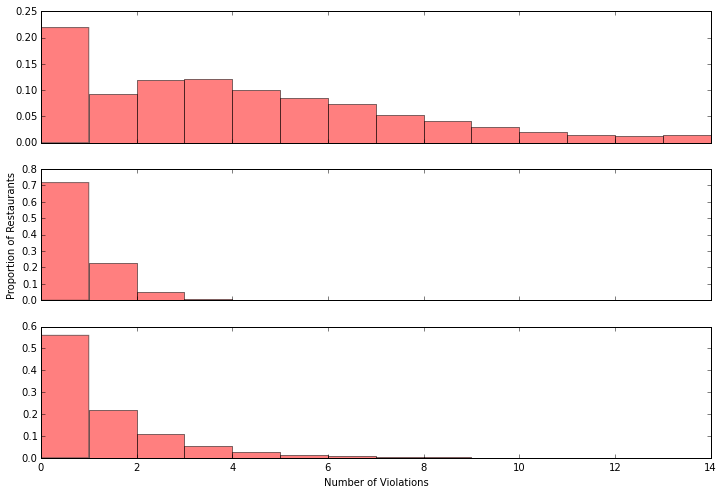

In [4]:
fig1, axs1 = matplotlib.pyplot.subplots(3, sharex=True)
fig1.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = train_df.reset_index()[label]
    axs1[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='red', alpha=0.5)
    
axs1[2].set_xlabel("Number of Violations")
axs1[1].set_ylabel("Proportion of Restaurants")

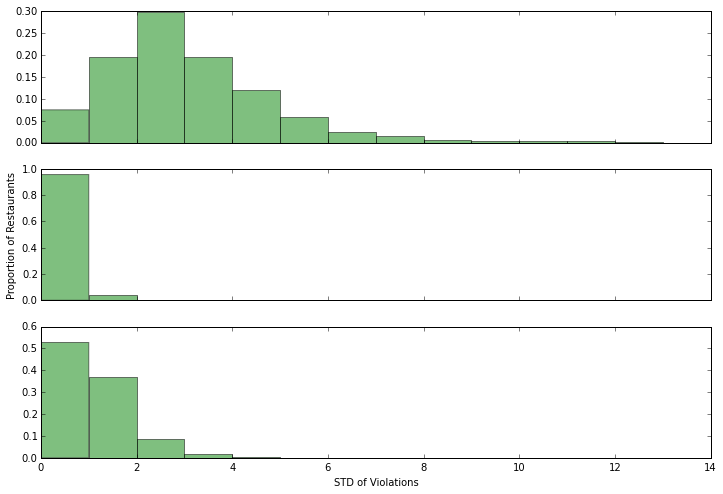

In [5]:
fig2, axs2 = matplotlib.pyplot.subplots(3, sharex=True)
fig2.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = train_df.reset_index().groupby("restaurant_id")[label].std()
    axs2[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='green', alpha=0.5)

axs2[2].set_xlabel("STD of Violations")
axs2[1].set_ylabel("Proportion of Restaurants")

In [6]:
singlets = train_df["restaurant_id"].isin(train_df.groupby("restaurant_id").count().query("date == 1").index)
doublets = train_df["restaurant_id"].isin(train_df.groupby("restaurant_id").count().query("date == 2").index)
zeros = train_df[["*", "**", "***"]] == 0
non_zeros = train_df[["*", "**", "***"]] != 0
singles_df = train_df[(doublets | singlets | first_inspections)]
non_singles_df = train_df[~(doublets | singlets | first_inspections)]

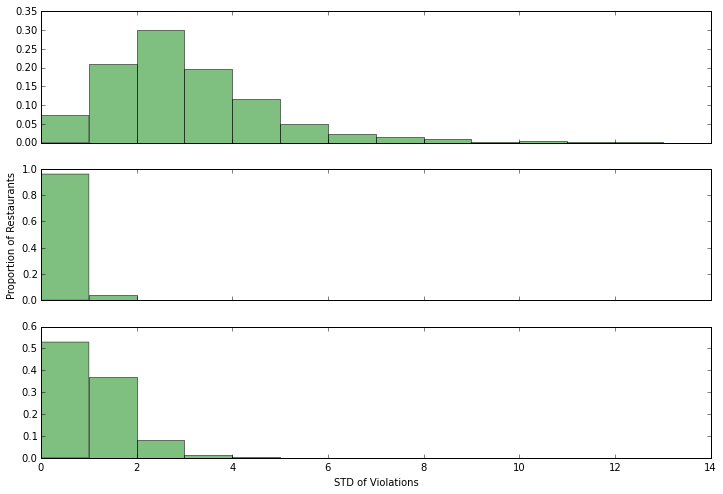

In [7]:
fig3, axs3 = matplotlib.pyplot.subplots(3, sharex=True)
fig3.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = non_singles_df.reset_index().groupby("restaurant_id")[label].std()
    axs3[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='green', alpha=0.5)

axs3[2].set_xlabel("STD of Violations")
axs3[1].set_ylabel("Proportion of Restaurants")

In [8]:
vec_log = numpy.vectorize(math.log)

def rmsle_w(p, y, weights=[1, 3, 5]):
    p = p.clip(0, numpy.inf)
    p = p.round(0)
    log_sum = 0
    if y.ndim == 1:
        p *= weights[0]
        p += 1
        log_pred = vec_log(p)
        y *= weights[0]
        y += 1
        log_true = vec_log(y)
        log_sum += pow(log_pred - log_true, 2).sum()
    else:
        for i in range(0, y.shape[1]):
            p[:,i] *= weights[i]
            p[:,i] += 1
            log_pred = vec_log(p[:,i])
            y[:,i] *= weights[i]
            y[:,i] += 1
            log_true = vec_log(y[:,i])
            log_sum += pow(log_pred - log_true, 2).sum()
    s = math.sqrt(1/y.shape[0] * log_sum)
    return s

def rmsle_score(estimator, X, y):
    return rmsle_w(estimator.predict(X), y)

In [30]:
# First, split on 0/non-0 and try to classify these restaurants
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
non_singles_predict_cols = ["p*", "p**", "p***", "last*", "last**", "last***", "std*", "std**", "std***"]

numeric_train_df = train_df.select_dtypes(include=numerics).copy()
numeric_train_df.drop(non_singles_predict_cols, inplace=True, axis="columns")
numeric_train_df.drop(["*", "**", "***"], inplace=True, axis="columns")
numeric_train_df_std = sklearn.preprocessing.StandardScaler().fit_transform(numeric_train_df)
#pca = sklearn.decomposition.RandomizedPCA(n_components=10, whiten=True)
#numeric_train_df_pca = pca.fit_transform(numeric_train_df_std)

best_classifiers = []
predicted_zeros = []
for label in ['*', '**', '***']:
    search = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KNeighborsClassifier(),
                                              param_grid={"n_neighbors": [2,5]},
                                              #n_iter=10,
                                              #scoring=rmsle_score,
                                              cv=3,
                                              refit=True,
                                              n_jobs=-1,
                                              verbose=2)
    search.fit(numeric_train_df_std, zeros[label])
    print("Best parameters:")
    print(search.best_params_)
    print("Best score:")
    print(search.best_score_)
    best_classifiers = best_classifiers + [search.best_estimator_]
    predicted_zeros = predicted_zeros + [search.best_estimator_.predict(numeric_train_df_std)]

[Parallel(n_jobs=-1)]: Done   1 out of   6 | elapsed:  1.9min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.2min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters:
{'n_neighbors': 2}
Best score:
0.734716479622
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.8min remaining:   54.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.0min finished



Best parameters:
{'n_neighbors': 5}
Best score:
0.642720023627
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.9min remaining:   56.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.4min finished



Best parameters:
{'n_neighbors': 5}
Best score:
0.535772297696


In [51]:
# Next, regress on non-zero singlets
best_singles_regressors = []
for pzs, label in zip(predicted_zeros, ['*', '**', '***']):
    search = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KNeighborsRegressor(),
                                                    param_grid={"n_neighbors": [3,5,7],
                                                                        "leaf_size": [5, 10, 30, 50]},
                                                    #n_iter=1,
                                                    scoring=rmsle_score,
                                                    cv=3,
                                                    refit=True,
                                                    verbose=2)
    search.fit(numeric_train_df[(pzs != 1) & (singlets | doublets | first_inspections)],
               train_df.loc[(pzs != 1) & (singlets | doublets | first_inspections), label])
    print("Best parameters:")
    print(search.best_params_)
    print("Best score:")
    print(search.best_score_)
    best_singles_regressors = best_singles_regressors + [search.best_estimator_]

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV] n_neighbors=7, leaf_size=5 ......................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.7s finished



Best parameters:
{'n_neighbors': 3, 'leaf_size': 5}
Best score:
0.9556903724573814
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.2s finished



[CV] n_neighbors=5, leaf_size=50 .....................................
[CV] ............................ n_neighbors=5, leaf_size=50 -   0.0s
[CV] n_neighbors=5, leaf_size=50 .....................................
[CV] ............................ n_neighbors=5, leaf_size=50 -   0.0s
[CV] n_neighbors=5, leaf_size=50 .....................................
[CV] ............................ n_neighbors=5, leaf_size=50 -   0.0s
[CV] n_neighbors=7, leaf_size=50 .....................................
[CV] ............................ n_neighbors=7, leaf_size=50 -   0.0s
[CV] n_neighbors=7, leaf_size=50 .....................................
[CV] ............................ n_neighbors=7, leaf_size=50 -   0.0s
[CV] n_neighbors=7, leaf_size=50 .....................................
[CV] ............................ n_neighbors=7, leaf_size=50 -   0.0s
Best parameters:
{'n_neighbors': 3, 'leaf_size': 5}
Best score:
0.5083701936027595
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.5s finished



Best parameters:
{'n_neighbors': 3, 'leaf_size': 5}
Best score:
0.8168470359397833


In [52]:
# For non-singlets/doublets, predict based on previous violation data
best_non_singles_regressors = []
for pzs, label in zip(predicted_zeros, ['*', '**', '***']):
    search = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KNeighborsRegressor(),
                                                    param_grid={"n_neighbors": [3,5,7],
                                                                        "leaf_size": [5, 10, 30, 50]},
                                                    #n_iter=1,
                                                    scoring=rmsle_score,
                                                    cv=3,
                                                    refit=True,
                                                    verbose=2)
    search.fit(train_df.loc[(pzs != 1) & ~(singlets | doublets | first_inspections), non_singles_predict_cols],
               train_df.loc[(pzs != 1) & ~(singlets | doublets | first_inspections), label])
    print("Best parameters:")
    print(search.best_params_)
    print("Best score:")
    print(search.best_score_)
    #print("Best coefficients:")
    #print(search.best_estimator_.coef_)
    best_non_singles_regressors = best_non_singles_regressors + [search.best_estimator_]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.2s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.2s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.2s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.3s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.3s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.3s
[CV] n_neighbors=7, leaf_size=5 ......................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   10.3s finished



Best parameters:
{'n_neighbors': 3, 'leaf_size': 5}
Best score:
0.8224867438563408
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.6s finished



Best parameters:
{'n_neighbors': 3, 'leaf_size': 30}
Best score:
0.4813898285919446
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.0s
[CV] n_neighbors=3, leaf_size=5 ......................................
[CV] ............................. n_neighbors=3, leaf_size=5 -   0.1s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.1s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.0s
[CV] n_neighbors=5, leaf_size=5 ......................................
[CV] ............................. n_neighbors=5, leaf_size=5 -   0.1s
[C

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    4.1s finished



Best parameters:
{'n_neighbors': 3, 'leaf_size': 30}
Best score:
0.6630181455264643


In [53]:
# Put everything together
prediction = pandas.DataFrame(index=train_df.index)
prediction["restaurant_id"] = train_df["restaurant_id"]
for n, label in enumerate(["*", "**", "***"]):
    pzs = predicted_zeros[n]
    nz_singlets = (pzs != 1) & (singlets | doublets | first_inspections)
    nz_non_singlets = (pzs != 1) & ~(singlets | doublets | first_inspections)
    
    prediction.loc[nz_non_singlets, label] = best_non_singles_regressors[n].predict(train_df.loc[nz_non_singlets, non_singles_predict_cols]).round()
    prediction.loc[nz_singlets, label] = best_singles_regressors[n].predict(numeric_train_df[nz_singlets]).round()
    prediction.loc[pzs == 1, label] = 0
prediction = prediction.clip_lower(0)
print(prediction.loc[:, ["*", "**", "***"]])
print(rmsle_w(prediction.loc[:, ["*", "**", "***"]].values, train_df.loc[:, ["*", "**", "***"]].values))

        *  **  ***
id                
28144   6   1    0
27691   4   1    0
24765   2   2    0
31333   2   2    0
25193   3   2    0
14328   3   1    0
12775   5   1    2
25850   2   0    1
17443   2   1    1
5576    5   1    1
4180    5   1    1
33309   9   1    2
3527   11   0    3
22246  11   0    3
17990   3   0    0
1601    4   0    0
20355   3   0    0
1028    4   0    1
14085   4   0    1
4772    4   1    3
17230   5   1    2
19976   5   1    2
8566    4   1    1
27872   5   1    1
10757   2   0    0
32641   9   0    0
7601    1   0    0
500     0   0    0
10435   0   0    0
6187    2   0    0
...    ..  ..  ...
2938    2   0    0
17434   9   0    3
6702    9   0    3
16639   9   0    3
16781   9   0    3
10410   9   0    3
10901   9   0    0
6928    9   0    0
5738    9   0    0
25560   9   0    0
6433    9   0    0
12800   9   0    0
15819   9   0    0
32107   9   0    3
26392   9   0    3
31085   9   0    3
6878   10   0    0
23210   8   0    0
23077   7   0    0
8107    5   

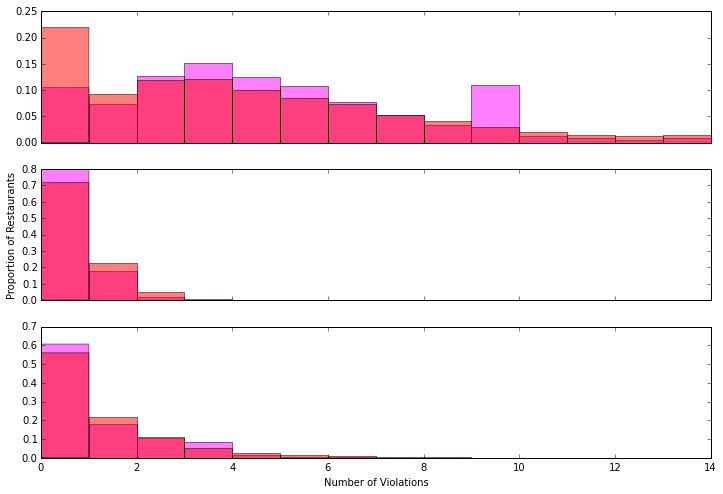

In [54]:
fig4, axs4 = matplotlib.pyplot.subplots(3, sharex=True)
fig4.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = prediction.reset_index()[label]
    real_data = train_df.reset_index()[label]
    axs4[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='magenta', alpha=0.5)
    axs4[i].hist(real_data, normed=True, bins=range(0, 15), facecolor='red', alpha=0.5)
    
axs4[2].set_xlabel("Number of Violations")
axs4[1].set_ylabel("Proportion of Restaurants")

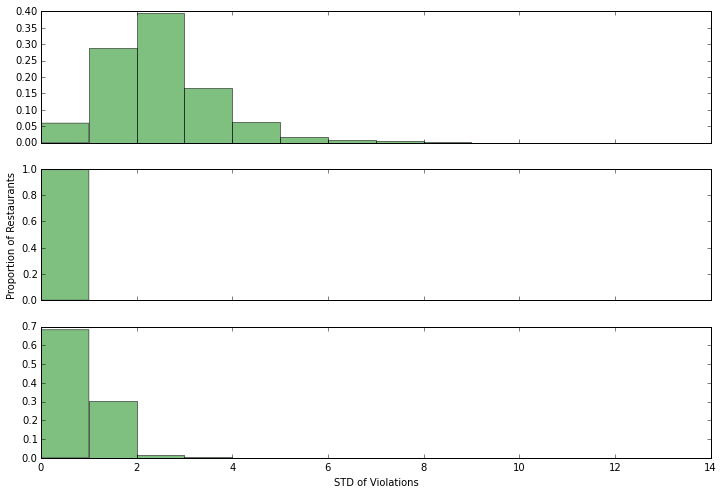

In [56]:
fig5, axs5 = matplotlib.pyplot.subplots(3, sharex=True)
fig5.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    train_data = prediction.reset_index().groupby("restaurant_id")[label].std()
    axs5[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='green', alpha=0.5)

axs5[2].set_xlabel("STD of Violations")
axs5[1].set_ylabel("Proportion of Restaurants")

In [57]:
phase2_df.shape

(80281, 290)

In [65]:
# predict!
phase1_df["first"] = 0
np1_df = phase1_df.select_dtypes(include=numerics).copy()
np1_df.drop(non_singles_predict_cols, inplace=True, axis="columns")
np1_df.drop(["*", "**", "***"], inplace=True, axis="columns")
np1_df_std = sklearn.preprocessing.StandardScaler().fit_transform(np1_df)
#pca = sklearn.decomposition.RandomizedPCA(n_components=10, whiten=True)
#numeric_train_df_pca = pca.fit_transform(numeric_train_df_std)

p1z = []
for cls, label in zip(best_classifiers, ['*', '**', '***']):
    p1z = p1z + [cls.predict(np1_df_std)]

In [73]:
prediction1 = pandas.DataFrame(index=phase1_df.index)
prediction1["restaurant_id"] = phase1_df["restaurant_id"]

singlets1 = phase1_df["restaurant_id"].isin(train_df.groupby("restaurant_id").count().query("date == 1").index)
doublets1 = phase1_df["restaurant_id"].isin(train_df.groupby("restaurant_id").count().query("date == 2").index)

for pzs, nsr, sr, label in zip(p1z, best_non_singles_regressors, best_singles_regressors, ["*", "**", "***"]):
    
    nz_singlets = (pzs != 1) & (singlets1 | doublets1)
    nz_non_singlets = (pzs != 1) & ~(singlets1 | doublets1)
    
    prediction1.loc[nz_non_singlets, label] = nsr.predict(phase1_df.loc[nz_non_singlets, non_singles_predict_cols]).round()
    prediction1.loc[nz_singlets, label] = sr.predict(np1_df[nz_singlets]).round()
    prediction1.loc[pzs == 1, label] = 0
    
prediction1 = prediction1.clip_lower(0)
print(prediction1.loc[:, ["*", "**", "***"]])

        *  **  ***
id                
7253    2   0    1
15277   2   1    1
31543  11   0    3
30988   4   0    1
10567   5   1    2
13937   5   1    1
1507    9   0    0
20867   0   0    0
10960   0   0    0
13713   5   1    2
983    10   1    2
19639   2   0    1
20611   2   0    1
31780   9   1    0
27313   6   0    0
20748   7   1    2
3614    7   1    2
12329   9   1    0
13712   9   0    0
126     9   0    0
31248   9   1    3
26581   2   1    2
15544   0   0    1
18320   0   0    1
7395    0   0    0
13974   9   0    3
10298   7   0    1
10150   4   0    0
19685   4   0    0
18726   0   0    1
...    ..  ..  ...
31934   3   1    0
12234   1   0    2
2693    9   0    0
26651   2   0    0
25251   2   0    0
16877   3   0    0
23179   3   0    0
15856   7   0    0
28448   7   0    0
10609   9   0    0
31141   2   0    0
3951    0   0    0
6680    0   0    0
33096   0   0    0
17741   5   1    0
28370   5   1    0
8116    0   0    0
6417    9   0    0
16266   9   0    0
26814   9   

In [68]:
# predict final!
phase2_df["first"] = 0
np2_df = phase2_df.select_dtypes(include=numerics).copy()
np2_df.drop(non_singles_predict_cols, inplace=True, axis="columns")
np2_df.drop(["*", "**", "***"], inplace=True, axis="columns")
np2_df_std = sklearn.preprocessing.StandardScaler().fit_transform(np2_df)
#pca = sklearn.decomposition.RandomizedPCA(n_components=10, whiten=True)
#numeric_train_df_pca = pca.fit_transform(numeric_train_df_std)

p2z = []
for cls, label in zip(best_classifiers, ['*', '**', '***']):
    p2z = p2z + [cls.predict(np2_df_std)]

In [72]:
prediction2 = pandas.DataFrame(index=phase2_df.index)
prediction2["restaurant_id"] = phase2_df["restaurant_id"]

singlets2 = phase2_df["restaurant_id"].isin(train_df.groupby("restaurant_id").count().query("date == 1").index)
doublets2 = phase2_df["restaurant_id"].isin(train_df.groupby("restaurant_id").count().query("date == 2").index)

for pzs, nsr, sr, label in zip(p2z, best_non_singles_regressors, best_singles_regressors, ["*", "**", "***"]):
    
    nz_singlets = (pzs != 1) & (singlets2 | doublets2)
    nz_non_singlets = (pzs != 1) & ~(singlets2 | doublets2)
    
    prediction2.loc[nz_non_singlets, label] = nsr.predict(phase2_df.loc[nz_non_singlets, non_singles_predict_cols]).round()
    prediction2.loc[nz_singlets, label] = sr.predict(np2_df[nz_singlets]).round()
    prediction2.loc[pzs == 1, label] = 0
    
prediction2 = prediction2.clip_lower(0)
print(prediction2.loc[:, ["*", "**", "***"]])

       *  **  ***
id               
51032  5   1    0
75643  5   1    0
22810  5   1    0
51621  5   1    0
7327   5   1    0
51795  5   1    0
4063   5   1    0
4665   5   1    0
6630   5   1    1
1744   5   1    1
72875  5   1    1
40895  5   1    1
21956  5   1    1
18151  5   1    1
39243  5   1    1
62842  5   1    1
50056  5   1    1
77931  5   1    1
61561  5   1    1
18693  5   1    1
6347   5   1    1
30034  5   1    1
44405  5   0    1
66989  5   0    1
12787  5   0    1
25630  5   0    1
37521  5   0    1
16880  5   0    1
50734  5   0    0
10433  5   0    0
...   ..  ..  ...
27592  2   0    1
43863  2   0    1
62171  2   0    1
78219  2   0    1
44751  2   0    1
5481   2   0    1
70902  2   0    1
38272  2   0    1
20558  2   0    0
22236  2   0    0
61317  2   0    0
4268   2   0    0
16101  2   0    0
23218  2   0    0
66360  2   0    0
68650  2   0    0
59032  2   0    0
62107  2   0    0
22730  2   0    0
30066  2   0    0
79380  2   0    0
79841  2   0    0
45280  2  

In [75]:
prediction1.to_csv("prediction_phase_1.csv", index="id")
prediction2.to_csv("prediction_phase_2.csv", index="id")

In [78]:
# Proper format now
p1_proper = pandas.DataFrame.from_csv("data/SubmissionFormat.csv", index_col="id")
p2_proper = pandas.DataFrame.from_csv("data/PhaseIISubmissionFormat.csv", index_col="id")

p1_proper[["*", "**", "***"]] = prediction1[["*", "**", "***"]].astype("int64")
p2_proper[["*", "**", "***"]] = prediction2[["*", "**", "***"]].astype("int64")

p1_proper.to_csv("prediction_phase_1_proper.csv", index="id")
p2_proper.to_csv("prediction_phase_2_proper.csv", index="id")